In [9]:
import pandas as pd
import numpy as np
import geopandas as gp
import geojson
from matplotlib import pyplot as plt

# Intro
The 50 states in U.S. have different areas, ranging from 4,001 km2 (RI) to 1,723,337 km2 (AK). This could sometimes cause huge challenges in visualization since smaller states would be hard to represent. 

Using a matrix map could help solve this problem. By abstract the US map into same-sized shapes while preserving the relative geographical positions, we could convey the information more precisely without bias when the area doesn't matter.

![US Matrix Map Sample](us_matrix_map_sample.png)

## Prepare Map Matrix

First we can use a spreadsheet to build up a matrix to abstract the real map. It looks something like below.

In [2]:
# Read in the data I prepared
us_map = pd.read_csv('desktop/OTD Goal/us_matrix_map.csv',header=None)
us_map

,0,1,2,3,4,5,6,7,8,9,10
0,AK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ME
1,NaN,NaN,NaN,NaN,NaN,WI,NaN,NaN,NaN,VT,NH
2,WA,ID,MT,ND,MN,IL,MI,NaN,NY,MA,NaN
3,OR,NV,WY,SD,IA,IN,OH,PA,NJ,CT,RI
4,CA,UT,CO,NE,MO,KY,WV,VA,MD,DE,NaN
5,NaN,AZ,NM,KS,AR,TN,NC,SC,DC,NaN,NaN
6,NaN,NaN,NaN,OK,LA,MS,AL,GA,NaN,NaN,NaN
7,HI,NaN,NaN,TX,NaN,NaN,NaN,NaN,FL,NaN,NaN


In [3]:
# Flatten the matrix
us_map = us_map.stack().reset_index()
us_map.columns = ['row','column','state']
us_map = us_map[us_map['state']!='']
us_map['row'] = us_map['row'].max() - us_map['row'] 
us_map.head()

,row,column,state
0,7,0,AK
1,7,10,ME
2,6,5,WI
3,6,9,VT
4,6,10,NH


## Generate Geojson File
Now we use the geojson module to translate our prepared data into a geojson file.

In [4]:
# Here I make a geojson file that can hold 1 overall value and 3 subtotal value for each state
features = []
value_holders = {'overall': {'start':[0,0], 'width':3, 'height':2},
          'subtotal1': {'start':[0,2], 'width':1, 'height':1},
          'subtotal2': {'start':[1,2], 'width':1, 'height':1},
          'subtotal3': {'start':[2,2], 'width':1, 'height':1}}
step = 4

for state in us_map.iterrows():
    state_name = state[1]['state']
    main_start_point_x = state[1]['column']
    main_start_point_y = state[1]['row']
    for value_holder in value_holders:
        aug = value_holders[value_holder]
        start_point_x = main_start_point_x * step + aug['start'][0] 
        start_point_y = main_start_point_y * step + aug['start'][1]
        feature = geojson.Feature(state_name, geojson.Polygon([[(start_point_x, start_point_y),
                                                                (start_point_x+aug['width'],start_point_y),
                                                                (start_point_x+aug['width'],start_point_y+aug['height']),
                                                                (start_point_x,start_point_y+aug['height']),
                                                                (start_point_x,start_point_y)]]), 
                                  properties={'type':value_holder})
        features.append(feature)
features = geojson.FeatureCollection(features)

with open('us_matrix_map.geojson','w') as w:
    w.write(geojson.dumps(features))

{"features": [{"geometry": {"coordinates": [[[0, 28], [3, 28], [3, 30], [0, 30], [0, 28]]], "type": "Polygon"}, "id": "AK", "properties": {"type": "overall"}, "type": "Feature"}, {"geometry": {"coordinates": [[[0, 30], [1, 30], [1, 31], [0, 31], [0, 30]]], "type": "Polygon"}, "id": "AK", "properties": {"type": "subtotal1"}, "type": "Feature"}, {"geometry": {"coordinates": [[[1, 30], [2, 30], [2, 31], [1, 31], [1, 30]]], "type": "Polygon"}, "id": "AK", "properties": {"type": "subtotal2"}, "type": "Feature"}, {"geometry": {"coordinates": [[[2, 30], [3, 30], [3, 31], [2, 31], [2, 30]]], "type": "Polygon"}, "id": "AK", "properties": {"type": "subtotal3"}, "type": "Feature"}, {"geometry": {"coordinates": [[[40, 28], [43, 28], [43, 30], [40, 30], [40, 28]]], "type": "Polygon"}, "id": "ME", "properties": {"type": "overall"}, "type": "Feature"}, {"geometry": {"coordinates": [[[40, 30], [41, 30], [41, 31], [40, 31], [40, 30]]], "type": "Polygon"}, "id": "ME", "properties": {"type": "subtotal1"}

## Using the Map
Now that we have the geojson file, we can use it to create matrix maps using multiple modules or softwares. Here I'll use Geopandas to make a sample map. The flexibility of Geopandas allow us to further edit the map's appearance.

In [5]:
# Read in the geojson file with Geopandas
us_map = gp.read_file('us_matrix_map.geojson')
us_map.head()

,id,type,geometry
0,AK,overall,"POLYGON ((0.00000 28.00000, 3.00000 28.00000, ..."
1,AK,subtotal1,"POLYGON ((0.00000 30.00000, 1.00000 30.00000, ..."
2,AK,subtotal2,"POLYGON ((1.00000 30.00000, 2.00000 30.00000, ..."
3,AK,subtotal3,"POLYGON ((2.00000 30.00000, 3.00000 30.00000, ..."
4,ME,overall,"POLYGON ((40.00000 28.00000, 43.00000 28.00000..."


In [6]:
# Generate some random data
us_map['data'] = np.random.randn(len(us_map))
us_map.head()

,id,type,geometry,data
0,AK,overall,"POLYGON ((0.00000 28.00000, 3.00000 28.00000, ...",-0.635572
1,AK,subtotal1,"POLYGON ((0.00000 30.00000, 1.00000 30.00000, ...",-0.317237
2,AK,subtotal2,"POLYGON ((1.00000 30.00000, 2.00000 30.00000, ...",1.884835
3,AK,subtotal3,"POLYGON ((2.00000 30.00000, 3.00000 30.00000, ...",1.109650
4,ME,overall,"POLYGON ((40.00000 28.00000, 43.00000 28.00000...",-0.456609


<ipython-input-7-06b8f72af8ba>:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  us_map['center'] = us_map['geometry'].centroid.apply(lambda c: (c.x, c.y))


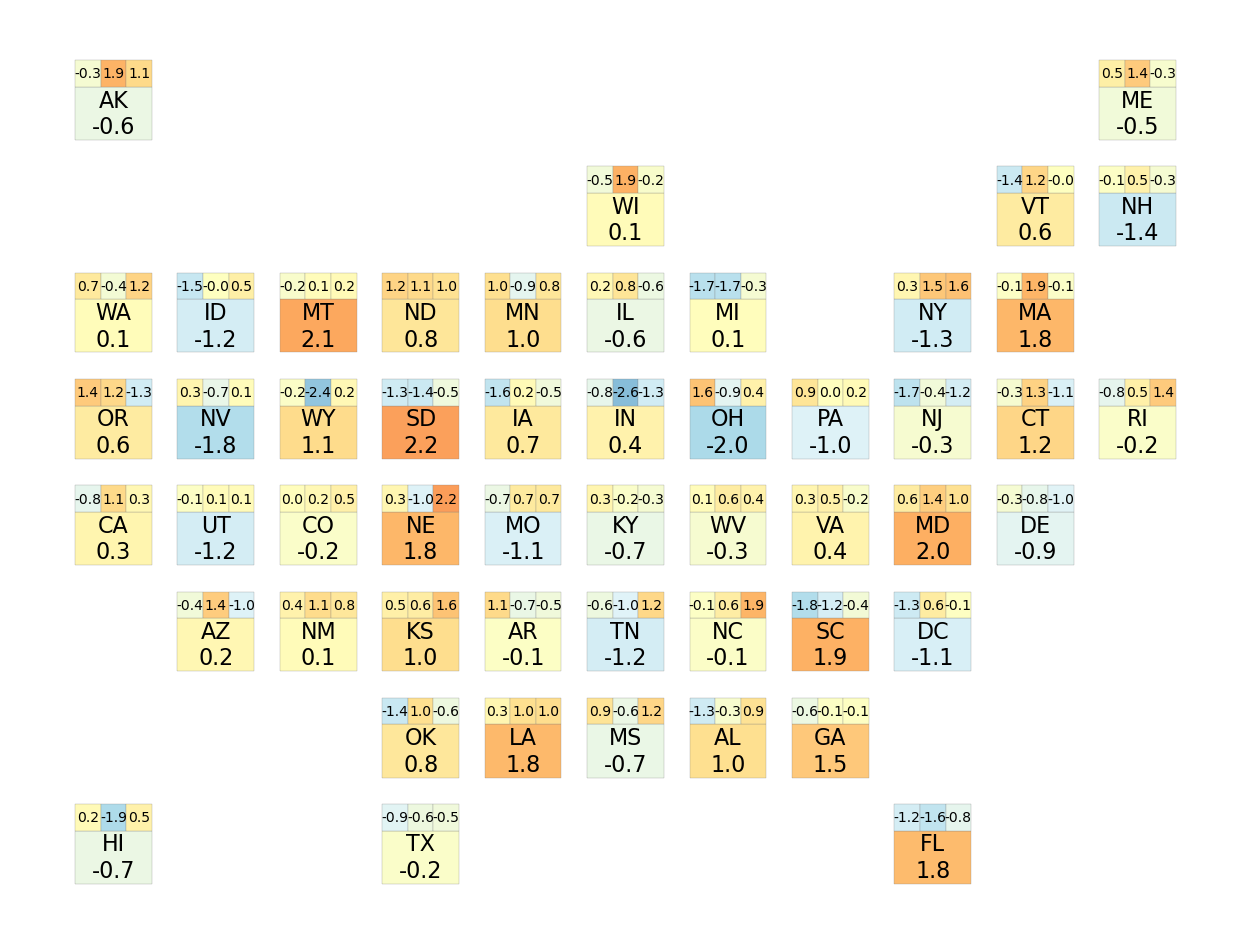

In [7]:
# Now lets make some maps!
fig = plt.figure(dpi=200,figsize=(10,6))
us_map.plot('data', ax=plt.gca(), cmap='RdYlBu_r', linewidth=0.1, edgecolor='grey', vmin=-5, vmax=5)
plt.axis(False)

# Add some text
us_map['center'] = us_map['geometry'].centroid.apply(lambda c: (c.x, c.y))
for row in us_map.iterrows():
    size = 5
    text = '{:.1f}'.format(row[1]['data'])
    if row[1]['type'] == 'overall':
        text = row[1]['id']+'\n'+text
        size = 8
    plt.annotate(text, row[1]['center'], horizontalalignment='center', verticalalignment='center', size=size)

<ipython-input-8-f1e368862819>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  us_map['geometry'] = us_map['geometry'].centroid.buffer(0.5)
<ipython-input-8-f1e368862819>:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  us_map['geometry'] = us_map['geometry'].centroid.buffer(0.5)
<ipython-input-8-f1e368862819>:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  us_map.loc[us_map['type']=='overall', 'geometry'] = us_map['geometry'].buffer(0.5)
<ipython-input-8-f1e368862819>:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoS

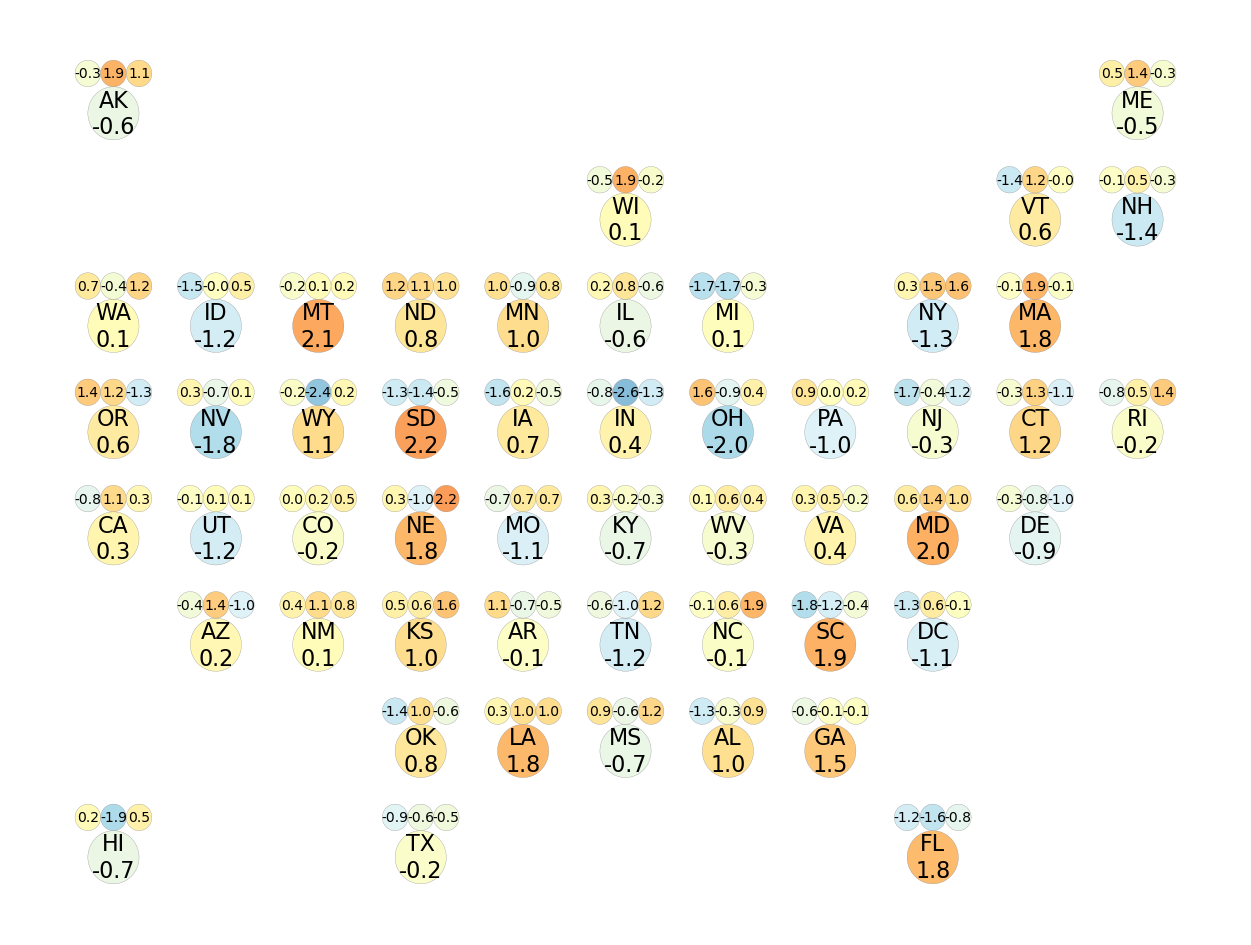

In [8]:
## We can also use Geopandas to adjust the shapes like changing them into circles!
us_map['geometry'] = us_map['geometry'].centroid.buffer(0.5)
us_map.loc[us_map['type']=='overall', 'geometry'] = us_map['geometry'].buffer(0.5)

fig = plt.figure(dpi=200,figsize=(10,6))
us_map.plot('data', ax=plt.gca(), cmap='RdYlBu_r', linewidth=0.1, edgecolor='grey', vmin=-5, vmax=5)
plt.axis(False)

# Add some text
us_map['center'] = us_map['geometry'].centroid.apply(lambda c: (c.x, c.y))
for row in us_map.iterrows():
    size = 5
    text = '{:.1f}'.format(row[1]['data'])
    if row[1]['type'] == 'overall':
        text = row[1]['id']+'\n'+text
        size = 8
    plt.annotate(text, row[1]['center'], horizontalalignment='center', verticalalignment='center', size=size)